# Helsinki Delivery Network Analysis
---
**Author:** Tigran Khachatryan

In [1]:
import random
from operator import itemgetter

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
%matplotlib inline

main_color = '#3cb4dc'

In [4]:
source_df = pd.read_csv('data/orders.csv')
df = source_df.copy()
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df.sample(5)

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
12793,2020-09-13 07:03:00,4,7,60.182,24.976,60.190,24.956,33,37,25.0,13.9,6.66650,0.00000
8325,2020-08-29 11:45:00,-4,2,60.166,24.930,60.188,24.960,41,37,0.0,16.7,3.40855,0.00000
14197,2020-09-17 12:04:00,2,4,60.158,24.932,60.170,24.945,39,41,0.0,8.9,9.70576,3.00000
13827,2020-09-16 09:47:00,0,1,60.168,24.922,60.169,24.937,38,38,0.0,13.9,4.23722,0.00000
10678,2020-09-06 10:14:00,19,4,60.155,24.948,60.169,24.941,35,54,75.0,15.6,4.16949,2.52632


In [5]:
def create_graph(df: pd.DataFrame) -> nx.Graph:
    """
    This function creates a nx.Graph object
    based on the input dataframe.
    ---
    Args:
        df: pd.Dataframe
        
    Returns: 
        G (nx.Graph): Graphs object from pandas O-D edge list.
    """

    df['origin'] = list(zip(df['VENUE_LONG'], df['VENUE_LAT']))
    df['destination'] = list(zip(df['USER_LONG'], df['USER_LAT']))

    G = nx.from_pandas_edgelist(df,
                                source='origin',
                                target='destination',
                                edge_attr=['ACTUAL_DELIVERY_MINUTES',
                                           'ESTIMATED_DELIVERY_MINUTES', 
                                           'ITEM_COUNT'],
                                create_using=nx.DiGraph()
                               )
    
    attrs = {}
    for index, node in enumerate(G.nodes()):
        attrs[node] = {'pos': node}
    nx.set_node_attributes(G, attrs)
    
    G = nx.convert_node_labels_to_integers(G, first_label=1)
    
    return G


G = create_graph(df)

In [6]:
def network_stats(G: nx.Graph) -> None:
    """
    This function prints the basic properties of the graph.
    ---
    Args:
        G (nx.Graph): Input network
    Returns: None
    """
    print(nx.info(G))
    
    avg_degree = sum([node_degree for node, node_degree in nx.degree(G)]) / float(G.number_of_nodes())
    print(f'Average Degree: {avg_degree}')

    density = nx.density(G)
    print(f'Edge Density: {density}')

    avg_clustering_coeff = nx.algorithms.cluster.average_clustering(G)
    print(f'Average Clustering Coefficient: {avg_clustering_coeff}')

    transitivity = nx.transitivity(G)
    print(f'Transitivity: {transitivity}')


    # In-degrees
    in_degree_dict = dict(G.in_degree(G.nodes()))
    sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 Users that have the most diverse diets (in degree):")
    for d in sorted_in_degree[:5]:
        print(d)
        
    # Out-degrees
    out_degree_dict = dict(G.out_degree(G.nodes()))
    sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 Venues with most unique users (out degree):")
    for d in sorted_out_degree[:5]:
        print(d)
        

network_stats(G)

DiGraph with 2098 nodes and 15901 edges
Average Degree: 15.158245948522403
Edge Density: 0.0036142694202485463
Average Clustering Coefficient: 0.09417141020441128
Transitivity: 0.011086976422078232

Top 5 Users that have the most diverse diets (in degree):
(322, 35)
(379, 33)
(456, 32)
(492, 32)
(556, 32)

Top 5 Venues with most unique users (out degree):
(39, 362)
(21, 350)
(9, 337)
(90, 337)
(100, 274)


2.0 6.0 11.0


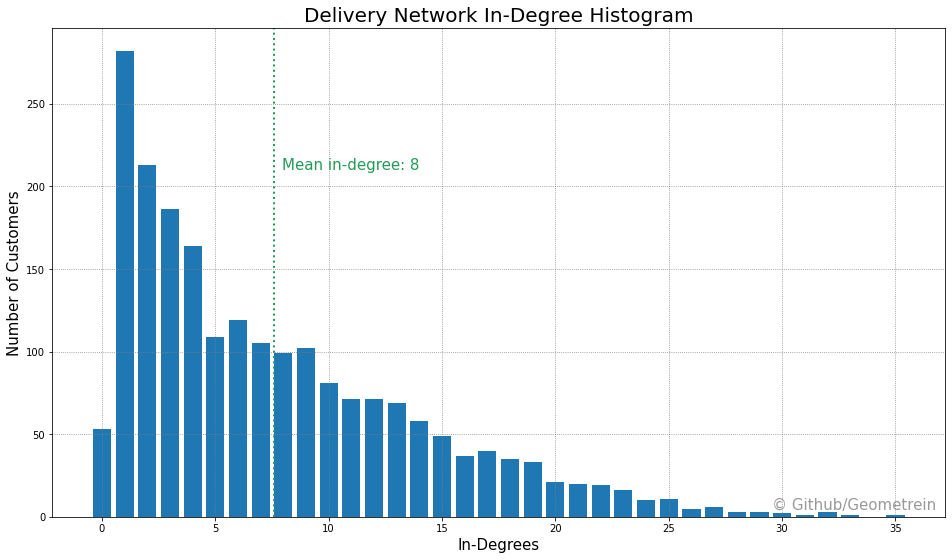

In [7]:
def plot_in_degree_hist(G: nx.digraph) -> None:
    """
    This function plots the in-degree distribution of the input Digraph.
    Args:
        G (nx.DiGraph): input Digraph
    Returns: None
    """
    # Data
    degree_sequence = sorted([d for n, d in G.in_degree(G.nodes())], reverse=True)
    avg_degree = sum(degree_sequence) / len(degree_sequence)
    
    q_25 = np.percentile(degree_sequence, 25)
    q_50=np.percentile(degree_sequence, 50)
    q_75=np.percentile(degree_sequence, 75)
    print(q_25, q_50, q_75)
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,9))
    ax.bar(*np.unique(degree_sequence, return_counts=True))
    plt.axvline(x=avg_degree, color='#239B56', linestyle=':', linewidth=2)
    
    # Labels & Grid
    ax.set_title("Delivery Network In-Degree Histogram", fontsize = 20)
    ax.set_xlabel("In-Degrees", fontsize = 15)
    ax.set_ylabel("Number of Customers", fontsize = 15)
    ax.grid(linestyle=":", color='grey')

    plt.text(x=avg_degree*1.05,
            y=210,
            s=f"Mean in-degree: {avg_degree:.0F}",
            color='#239B56',
            fontsize=15
    )

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)
    
    plt.show()

plot_in_degree_hist(G)

2.0 6.0 11.0 9.0


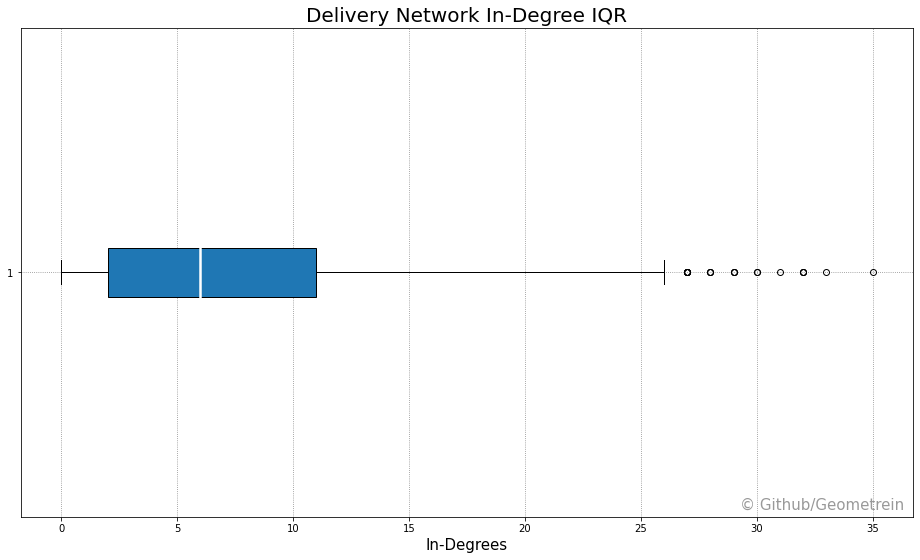

In [8]:
def plot_degree_iqr(G: nx.graph) -> None:
    """
    This function plots the inter-quantile range
    of in degrees of the input Digraph.
    ---
    Args:
        G (nx.DiGraph): input Digraph
    Returns: None
    """
    # Data
    degree_sequence = sorted([d for n, d in G.in_degree(G.nodes())], reverse=True)
    
    q_25 = np.percentile(degree_sequence, 25)
    q_50=np.percentile(degree_sequence, 50)
    q_75=np.percentile(degree_sequence, 75)
    print(q_25, q_50, q_75, q_75-q_25)
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Medianprops for the plot
    medianprops = dict(linestyle='-', linewidth=2.5, color='white')

    # Boxplot
    box = ax.boxplot(degree_sequence, vert=False, patch_artist=True, widths=0.1, whis = 1.7, medianprops=medianprops)
    
    # Labels & Grid
    ax.set_title("Delivery Network In-Degree IQR", fontsize = 20)
    ax.set_xlabel("In-Degrees", fontsize = 15)
    ax.grid(linestyle=":", color='grey')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)
    
    plt.show()


plot_degree_iqr(G)

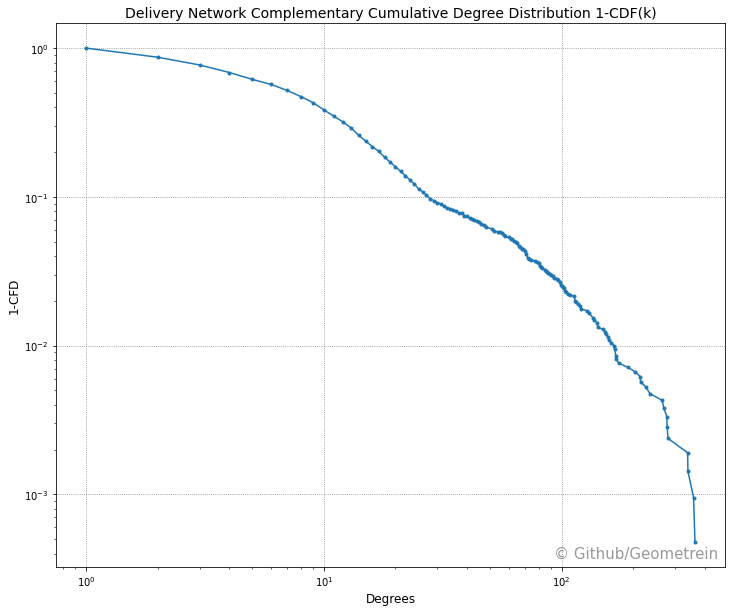

In [9]:
def cdf(G: nx.Graph) -> tuple:
    """
    This function Calculates the cumulative distribution function of input Graph:
    cdf(k) = p that value smaller than k
    ---
    Args:
         G (nx.Graph): Input network

    Returns:
        x_points (np.array): the values for which the cdf is computed
        cdf (np.array): cdf for the above values 
    """
    degrees = []
    degree = G.degree()
    for (n,d) in degree:
        degrees.append(d)
        
    input_array = np.array(degrees)
    x_points = np.unique(input_array) 
    cdf = []
    normalizer=float(input_array.size)

    for x in x_points:
        cdf.append((input_array[np.where(input_array < x)].size)/normalizer)

    return (x_points, np.array(cdf))


def plot_distribution(y_values: np.array, x_values: np.array) -> None:
    """
    Plots the pre-calculated distribution y(x)
    Returns the figure object
    Args:
        y_values (np.array): 1-cdf values
        x_values (np.array): the values for which the cdf is computed
    Returns: None
    """
    fig = plt.figure(figsize=(12,10))
    
    ax = fig.add_subplot(111) 
    ax.set_title('Delivery Network Complementary Cumulative Degree Distribution 1-CDF(k)', fontsize = 14)
    ax.loglog(x_values, y_values, marker='.')
    
    ax.set_xlabel('Degrees', fontsize = 12)
    ax.set_ylabel('1-CFD', fontsize = 12) 
    
    # Legend & Grid
    plt.grid(linestyle=":", color='grey')
    
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)
    
    plt.show()

cdf_x_values, cdf_vals = cdf(G)
plot_distribution(1-cdf_vals, cdf_x_values)

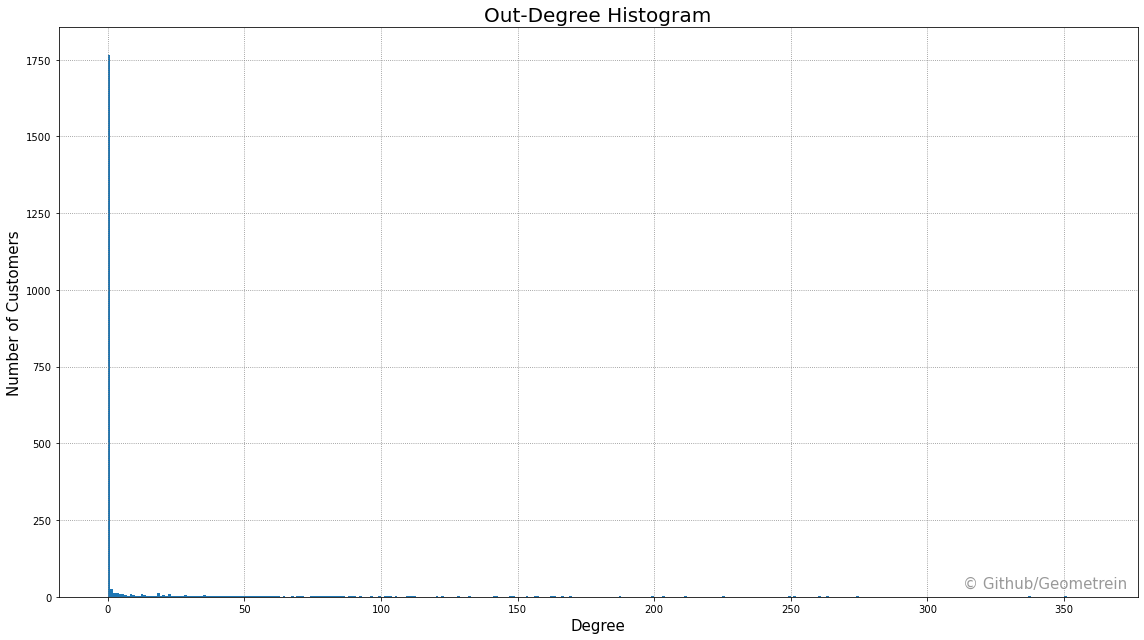

In [10]:
def plot_out_degree_hist(G: nx.graph) -> None:
    """
    This function plots the histogram of out-degrees of te input DiGraph
    ---
    Args:
        G (nx.DiGraph): input DiGraph
    Returns: None
    """
    degree_sequence = sorted([d for n, d in G.out_degree(G.nodes())], reverse=True)

    fig, ax = plt.subplots(figsize=(16,9))
    ax.hist(degree_sequence, bins=range(0,360))
    ax.set_title("Out-Degree Histogram", fontsize = 20)
    ax.set_xlabel("Degree", fontsize = 15)
    ax.set_ylabel("Number of Customers", fontsize = 15)
    ax.grid(linestyle=":", color='grey')
    
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)
    
    fig.tight_layout()
    plt.show()


plot_out_degree_hist(G)

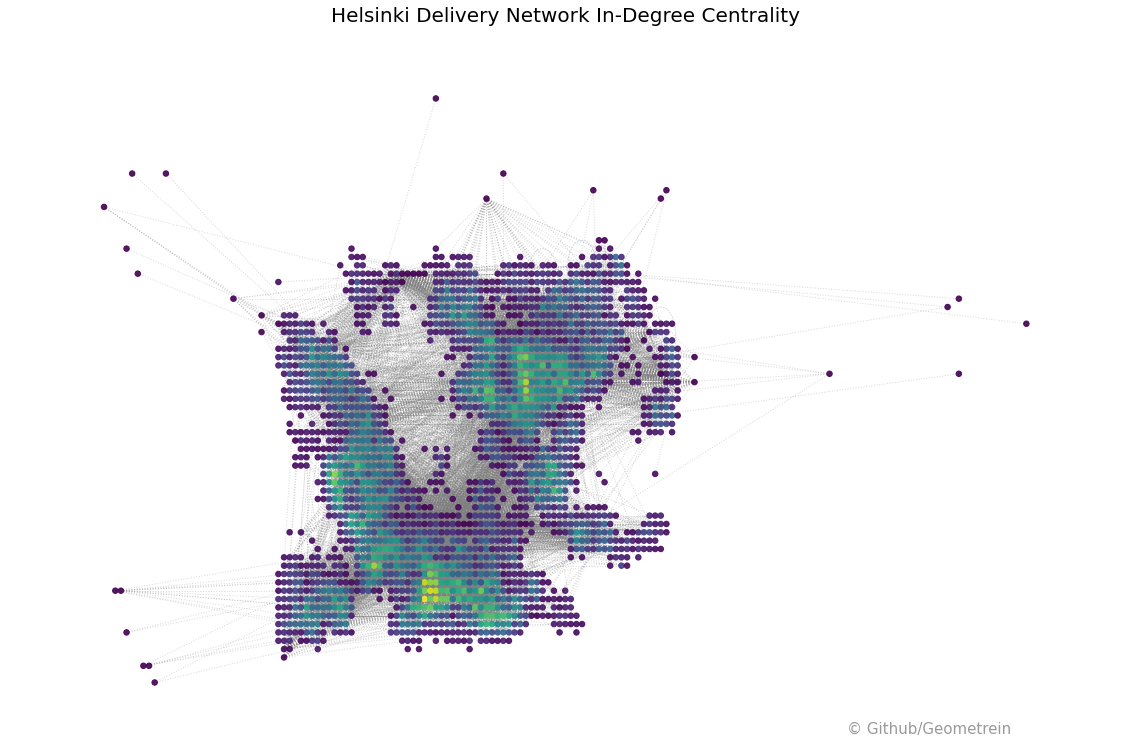

In [11]:
def plot_in_centrality_degree(G: nx.Graph) -> dict:
    """
    This function plots the nodes by in-degree centrality.
    ---
    Args:
        G (nx.DiGraph): input DiGraph
    Returns: 
        (dict): dictionary with nodes as keys and  and in-degrees as values
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20, 13), facecolor='w')
    
    # Data
    in_degree = nx.in_degree_centrality(G)
    node_color = [in_degree[i] for i in in_degree.keys()]

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos'), node_color=node_color, cmap="viridis", alpha=.9, node_size=30)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos'), edge_color='grey', style =":", alpha=0.3, arrows=False)

    # Labeling
    ax.set_title('Helsinki Delivery Network In-Degree Centrality', fontdict={"fontsize":20}, pad=15)
    ax.axis('off')
    
    # Watermark
    ax.text(0.90, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.8)

    return in_degree
    
in_degree = plot_in_centrality_degree(G)

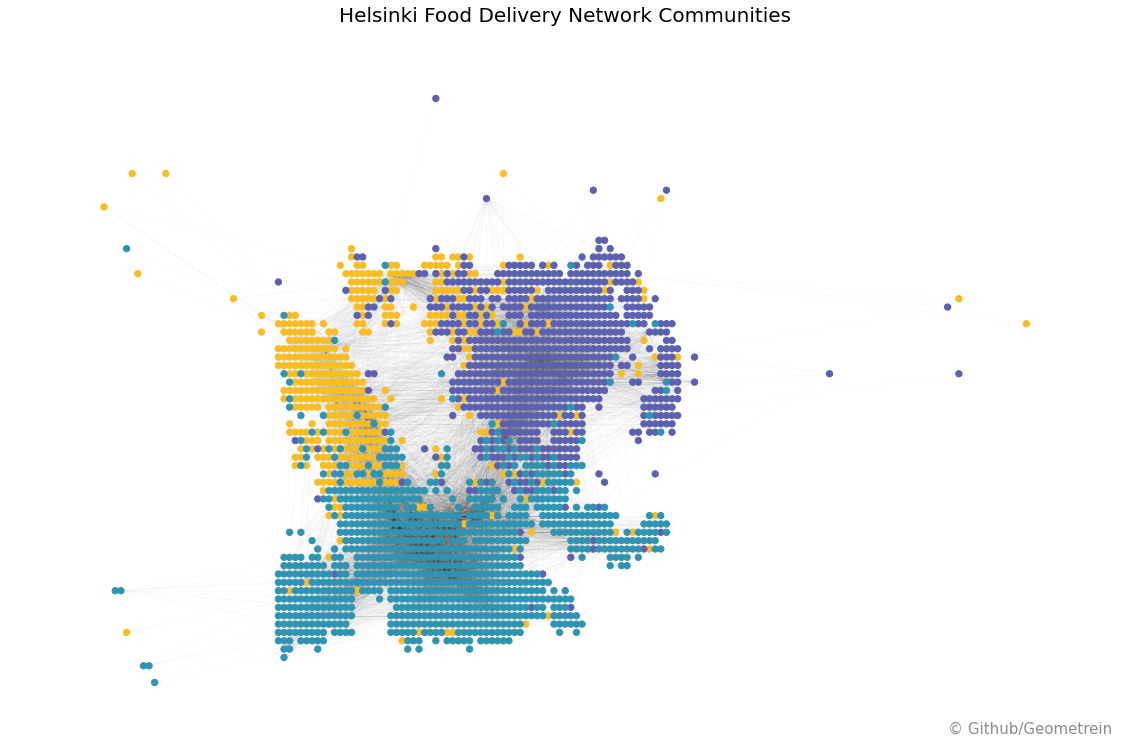

In [12]:
def communityFluid(G: nx.Graph) -> None:
    """
    This function applies the Fluid Communities method
    for community detection on the input graph.
    ---
    Args:
        G (nx.Graph): input Graph
    Returns: None
    """

    # Figure
    fig, ax = plt.subplots(figsize=(20,13), facecolor='w')

    # Compute Fluid method
    communities = nx.algorithms.community.asyn_fluid.asyn_fluidc(G, k=3, max_iter=10000, seed=5)
    
    # Assigning each node to its cluster
    partition = {}
    for idx, val in enumerate(communities):
        for k in val:
            partition[k] = idx

    # Partition colormap
    cmap = cm.get_cmap('tab10', max(partition.values())+1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#F9BD24","#5B61AE","#2E94B2"])

    # Draw Nodes
    nx.draw_networkx_nodes(G=G,
                           pos=G.nodes.data('pos'),
                           nodelist=partition.keys(),
                           node_size=40,
                           cmap=cmap,
                           node_color=list(partition.values())
    )
    
    # Draw Edges
    nx.draw_networkx_edges(G=G,
                           pos=G.nodes.data('pos'),
                           alpha=0.015
    )

    # Labeling Axes
    ax.set_title('Helsinki Food Delivery Network Communities',
                 fontdict={"fontsize":20},
                 pad=15)
    
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()
    
communityFluid(G.to_undirected())

Now plotting: random
Now plotting: w_big_first
Now plotting: w_small_first


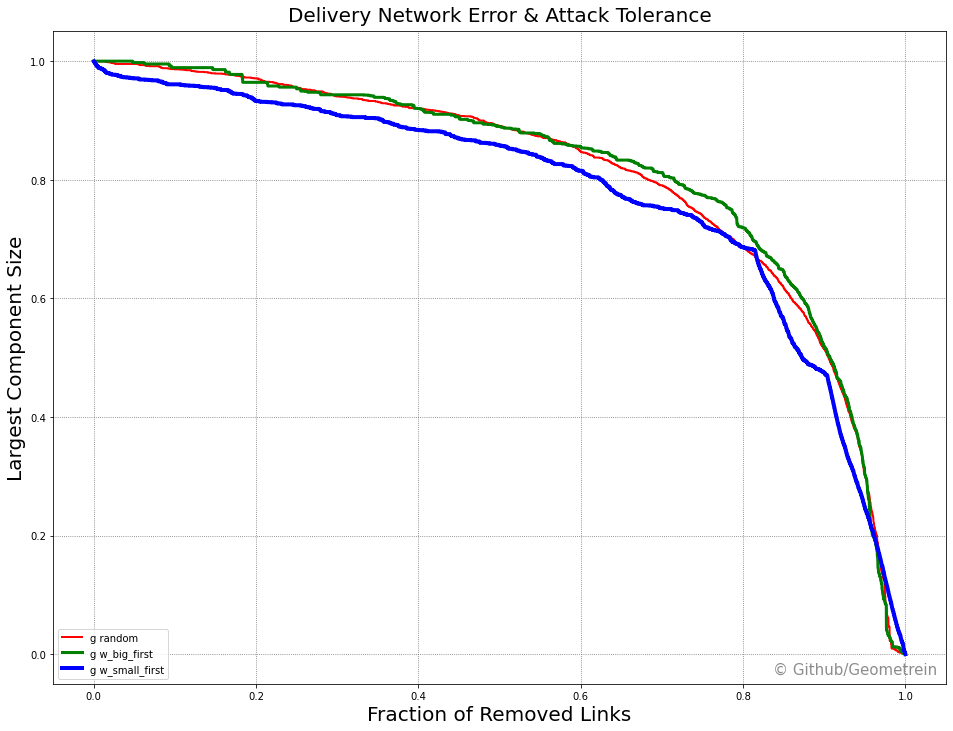

In [13]:
def get_giant_size(G: nx.Graph) -> int:
    """
    Calculates the size of the giant component of the network.
    ---
    Args:
        G (nx.Graph): Input graph
    Returns:
        giant_size (int): size of the giant component
    """
    components = (G.subgraph(c) for c in nx.algorithms.components.connected_components(G))
    return max(map(len, components))


def simulate_edge_removal(orignet: nx.Graph, order: list) -> list:
    """
    This function performs an edge removal simulation.
    ---
    Args:
        orignet (nx.Graph): Network in which the edge removal is simulated.
        order (list): network edges sorted in the order in which they will be removed
    Returns:
        giant_sizes (np.array): sizes of the giant component at different edge densities
    """
    giant_sizes = []
    net = orignet.copy()
    for edge in order:
        net.remove_edge(*edge)
        giant_size = get_giant_size(net)
        giant_sizes.append(giant_size)

    return giant_sizes


def run_link_removal(G: nx.Graph) -> plt.figure:
    """
    This function runs the edge removal simulation.
    ---
    Args:
        G (nx.Graph): Input graph
    Returns: None
    """
    net = G
    N = len(net.nodes())
    edges = list(net.edges())
    
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)

    random_edge_order = []
    random_edge_order = edges.copy()
    random.shuffle(random_edge_order)
    
    weigths = {}
    for edge in G.edges():
        node_1 = edge[0]
        node_2 = edge[1]
        degree_1 = G.degree[node_1]
        degree_2 = G.degree[node_2]
        weigths[edge] = degree_1 + degree_2
        
    nx.set_edge_attributes(net, weigths, "weight")
    ascending_weight_edge_order = sorted(edges, key=lambda edge: net.get_edge_data(*edge)['weight'])
    descending_weight_edge_order = ascending_weight_edge_order[::-1]
    
    # Edge removal:
    for order, order_name, color, ls, lw in zip(
        [random_edge_order, descending_weight_edge_order, ascending_weight_edge_order],
        ['random edges', 'important edges first', 'unimportant edges first'],
        ["r", "g", "b"],
        ["-", "-", "-"],
        [2, 3, 4]):

        print("Now plotting:", order_name)

        giant_sizes = simulate_edge_removal(net, order)
        fracs = np.linspace(0, 1, len(giant_sizes))

        ax.plot(fracs, np.array(giant_sizes) / float(N), color=color, ls=ls,
                label="g " + order_name, lw=lw)

        ax.set_ylabel('Largest Component Size', fontsize=20)
        ax.set_xlabel('Fraction of Removed Links', fontsize=20)
        ax.grid(linestyle=":", color='#696969')
        ax.set_title( 'Delivery Network Error & Attack Tolerance', fontsize=20, pad=10)
        ax.legend(loc='lower left')
        
    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)
    
    return fig


fig = run_link_removal(G.to_undirected())
fig.savefig("./images/error_and_attack_tolerance_edges.pdf")

Now plotting: Random Nodes
Now plotting: High Degree First
Now plotting: Low Degree First


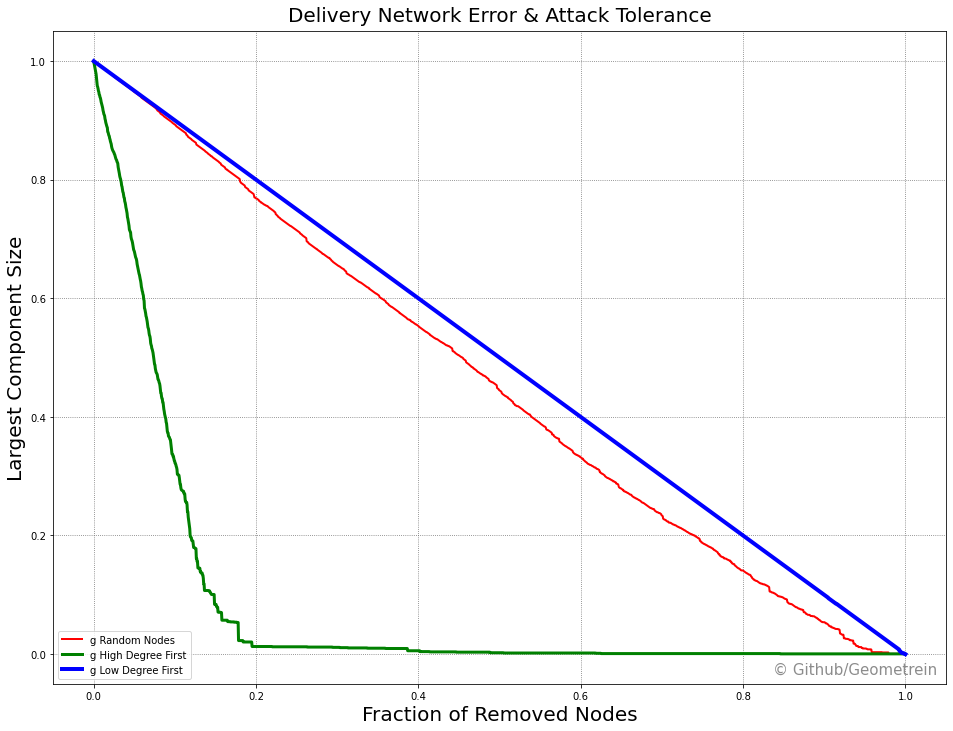

In [14]:
def get_giant_size(G) -> int:
    """
    This function calculates the size of the giant component of the network.
    ---
    Args:
        G (nx.Graph): Input graph
    Returns:
        giant_size (int): size of the giant component
    """
    largest_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    try:
        return largest_cc[0]
    except:
        return 0


def simulate_node_removal(orignet: nx.Graph, order: list) -> list:
    """
    This function performs an node removal simulation.
    ---
    Args:
        orignet (nx.Graph): Network in which the edge removal is simulated.
        order (list): network nodes sorted in the order in which they will be removed
    Returns:
        giant_sizes (np.array): sizes of the giant component at different edge densities
    """
    giant_sizes = []
    net = orignet.copy()
    for node in order:
        if node in G.nodes():
            net.remove_node(node)
            giant_size = get_giant_size(net)
            giant_sizes.append(giant_size)

    return giant_sizes


def run_node_removal(G: nx.Graph) -> plt.figure:
    """
    Sets up framework and runs the edge removal simulation.
    ---
    Args:
        G (nx.Graph): 
    Returns:
        fig (plt.fig):
    """
    net = G.copy()
    N = len(net.nodes())
    nodes = list(net.nodes())
    
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(111)

    random_node_order = []
    random_node_order = nodes.copy()
    random.shuffle(random_node_order)
    
    descending_degree_node_order = sorted(net.degree, key=lambda x: x[1], reverse=True)
    ascending_degree_node_order = sorted(net.degree, key=lambda x: x[1], reverse=False)
    
    descending_degree_node_order_nodes = [x[0]for x in descending_degree_node_order]
    ascending_degree_node_order_nodes = [x[0]for x in ascending_degree_node_order]
    
    # Node removal:
    for order, order_name, color, ls, lw in zip(
        [random_node_order, descending_degree_node_order_nodes, ascending_degree_node_order_nodes],
        ['Random Nodes', 'High Degree First', 'Low Degree First'],
        ["r", "g", "b"],
        ["-", "-", "-"],
        [2, 3, 4]):

        print("Now plotting:", order_name)

        giant_sizes = simulate_node_removal(net, order)
        fracs = np.linspace(0, 1, len(giant_sizes))

        ax.plot(fracs, np.array(giant_sizes) / float(N), color=color, ls=ls,
                label="g " + order_name, lw=lw)

        ax.set_ylabel('Largest Component Size',fontsize=20)
        ax.set_xlabel('Fraction of Removed Nodes',fontsize=20)
        ax.grid(linestyle=":", color='#696969')
        ax.set_title('Delivery Network Error & Attack Tolerance', fontsize=20, pad=10)
        ax.legend(loc='lower left')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    return fig


fig=run_node_removal(G.to_undirected())
fig.savefig("./images/error_and_attack_tolerance_nodes.pdf")

In [15]:
def grow_network(G: nx.Graph, N: int) -> nx.Graph:
    """
    This function simulates input network growth.
    ---
    Args:
        G (nx.Graph): Input graph
        N (int): Number of nodes after growth simulation
    Returns: 
        G (nx.Graph): Input graph
    """
    # Estimate the number of links the new node will have
    # based on the existing network in-degrees distribution
    in_degrees = []
    for n, d in G.in_degree():
        for k in range(d):
            in_degrees.append(n)
    random_node = np.random.choice(in_degrees)
    m = G.degree[random_node]

    nodes_repeated_by_degree = []
    for node, degree in G.out_degree():
        for k in range(degree):
            nodes_repeated_by_degree.append(node)

    number_of_nodes = len(G)
    while number_of_nodes < N:
        node_picks = set()
        while len(node_picks) < m:
            random_node = np.random.choice(nodes_repeated_by_degree)
            node_picks.add(random_node)

        new_node = [number_of_nodes] * m
        node_pairs = zip(node_picks, new_node)
        G.add_edges_from(node_pairs)
        nodes_repeated_by_degree += node_picks
        nodes_repeated_by_degree.extend(new_node)
        number_of_nodes += 1
        
    return G


simulated_G = grow_network(G, N=5001)
network_stats(simulated_G)

DiGraph with 5000 nodes and 56543 edges
Average Degree: 22.6172
Edge Density: 0.002262172434486897
Average Clustering Coefficient: 0.05387902799412406
Transitivity: 0.0036564933085330665

Top 5 Users that have the most diverse diets (in degree):
(322, 35)
(379, 33)
(456, 32)
(492, 32)
(556, 32)

Top 5 Venues with most unique users (out degree):
(39, 881)
(21, 840)
(90, 803)
(9, 788)
(137, 671)
